<a href="https://colab.research.google.com/github/gjurcin/google_stock_prediction/blob/main/Google_Stocks_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WS - Google Stocks Prediction (RNN/LSTM)

The problem to solve is Google Stocks prediction - regression (time series).
  - Train: https://drive.google.com/file/d/1VrrGQJpZ7ETCnui7xX6UAjz6uH9ZPZzY/view?usp=sharing
  - Test: https://drive.google.com/file/d/1l3gD2oyn8kXP3v-z-fcrks-QaUac7N9Z/view?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dense, SimpleRNN, Input, RepeatVector, GRU
from keras.models import Model
from keras.optimizers import SGD, Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Dataset

The dataset is already divided in train and test.

There are multiple columns. You work only with the column *High*.  

Bonus: Based on the columns High and the Date, you can calculate additional features

In [2]:
#import the dataset and print the dataframe
from google.colab import files
uploaded = files.upload()

Saving Google_Stock_Price_Test.csv to Google_Stock_Price_Test.csv
Saving Google_Stock_Price_Train.csv to Google_Stock_Price_Train.csv


In [142]:
# print the basic statistics about the dataset (train and test separately). 
# What is the mean value of the stocks?
train = pd.read_csv('/content/Google_Stock_Price_Train.csv')
test = pd.read_csv('/content/Google_Stock_Price_Test.csv')

In [143]:
train.head(5)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [144]:
train.Date = pd.to_datetime(train.Date, format='%m/%d/%Y')

In [145]:
test.head(5)

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [148]:
test.Date = pd.to_datetime(test.Date, format='%m/%d/%Y')

In [149]:
#train['Close'].astype('float')
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1258.0,533.709833,151.904442,279.12,404.115,537.47,654.9225,816.68
High,1258.0,537.880223,153.008811,281.21,406.765,540.75,662.5875,816.68
Low,1258.0,529.007409,150.552807,277.22,401.765,532.99,644.8000,805.14


In [150]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,20.0,807.5260,15.125428,778.81,802.9650,806.995,809.5600,837.81
High,20.0,811.9265,14.381198,789.63,806.7350,808.640,817.0975,841.95
Low,20.0,801.9495,13.278607,775.80,797.4275,801.530,804.4775,827.01
Close,20.0,807.9045,13.210088,786.14,802.2825,806.110,810.7600,835.67


In [151]:
# Visualize the dataset in a plot (train and test)
train = train.set_index('Date')
test = test.set_index('Date')

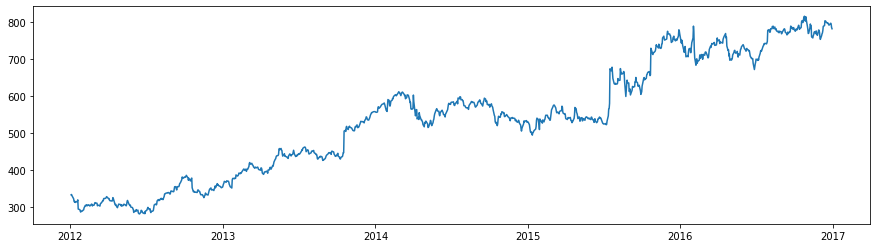

In [152]:
plt.figure(figsize=(15, 4))
plt.plot(train.index, train.High)
plt.show()

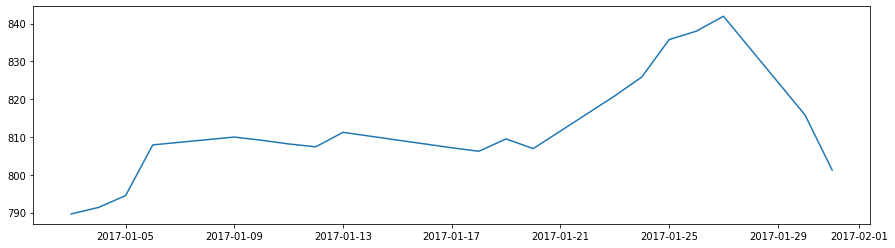

In [153]:
plt.figure(figsize=(15, 4))
plt.plot(test.index, test.High)
plt.show()

## Prepare the dataset

In [154]:
# normalize the dataset (0,1)
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaler_test = MinMaxScaler(feature_range=(0, 1))

sequence_train = train.High.values
sequence_test = test.High.values

print(sequence_train.shape, sequence_test.shape)

(1258,) (20,)


In [155]:
sequence_train = scaler_train.fit_transform(sequence_train.reshape(-1, 1))
sequence_test = scaler_test.fit_transform(sequence_test.reshape(-1, 1))

In [156]:
print(sequence_train.shape, sequence_test.shape)

(1258, 1) (20, 1)


# 2. Many to One

In [157]:
# write or reuse a function to segment the dataset in the appropriate format 
# Tip: function_name (dataset, n_steps_in)
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [158]:
# Use the function on the dataset and print the newly segmented data
# use n_steps_in = 5
n_steps_in = 5
trainX, trainY = create_dataset(sequence_train, n_steps_in)
testX, testY = create_dataset(sequence_test, n_steps_in)

In [159]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1252, 5) (1252,) (14, 5) (14,)


In [160]:
for i in range(5):
	print(trainX[i], trainY[i])

[0.09640129 0.09834351 0.09251685 0.08881917 0.07671765] 0.06444805497973749
[0.09834351 0.09251685 0.08881917 0.07671765 0.06444805] 0.06033951481875732
[0.09251685 0.08881917 0.07671765 0.06444805 0.06033951] 0.06358899658244166
[0.08881917 0.07671765 0.06444805 0.06033951 0.063589  ] 0.058061142547668476
[0.07671765 0.06444805 0.06033951 0.063589   0.05806114] 0.06274861336769577


In [161]:
# reshape the data to be appropriate for trianing the RNN/LSTM model
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape (testX.shape[0], testX.shape[1], 1)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1252, 5, 1) (1252,) (14, 5, 1) (14,)


## Create the model

In [162]:
# create and fit the RNN/LSTM network. 
# Use LSTM with 60 neurons, RELU activation function, MAE as a loss, and SGD as optimizer.
def one_layered_LSTM(input_shape, num_neurons):
  _input = Input(shape=input_shape, dtype='float')
  lstm_layer = LSTM(num_neurons, activation='relu', input_shape=input_shape, name='hidden_1')(_input)
  output = Dense(1)(lstm_layer)
  my_model = Model(inputs=[_input], outputs=[output])
  optimizer = Adam()
  my_model.compile(optimizer=optimizer, loss='mse')
  return my_model

num_features = trainX.shape[2]
num_timestamps = trainX.shape[1]
input_shape = (num_timestamps, num_features)
model_lstm =  one_layered_LSTM(input_shape, num_neurons=30)
model_lstm.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
hidden_1 (LSTM)              (None, 30)                3840      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


### Define the callbacks

In [163]:
# Callback1 - to save the best model in a file : "best_RNN.pt"
# Callback2 - to stop if there is no improvement in 15 epochs

callback1 = ModelCheckpoint('best_LSTM.pt', monitor='loss', save_best_only=True, mode='min', verbose=1)
callback2 = EarlyStopping(patience=20, monitor='loss', mode='min')
callback_list = [callback1, callback2]

### Train the model and use the callbacks
 - epoch = 150, batch size is 1

In [164]:
h = model_lstm.fit(trainX, trainY,
                   epochs= 50,
                   batch_size=20,
                   callbacks=callback_list,
                   validation_data=(testX, testY),
                   verbose=0)


Epoch 00001: loss improved from inf to 0.13262, saving model to best_LSTM.pt
INFO:tensorflow:Assets written to: best_LSTM.pt/assets

Epoch 00002: loss improved from 0.13262 to 0.00488, saving model to best_LSTM.pt
INFO:tensorflow:Assets written to: best_LSTM.pt/assets

Epoch 00003: loss improved from 0.00488 to 0.00165, saving model to best_LSTM.pt
INFO:tensorflow:Assets written to: best_LSTM.pt/assets

Epoch 00004: loss improved from 0.00165 to 0.00087, saving model to best_LSTM.pt
INFO:tensorflow:Assets written to: best_LSTM.pt/assets

Epoch 00005: loss improved from 0.00087 to 0.00054, saving model to best_LSTM.pt
INFO:tensorflow:Assets written to: best_LSTM.pt/assets

Epoch 00006: loss improved from 0.00054 to 0.00051, saving model to best_LSTM.pt
INFO:tensorflow:Assets written to: best_LSTM.pt/assets

Epoch 00007: loss did not improve from 0.00051

Epoch 00008: loss did not improve from 0.00051

Epoch 00009: loss did not improve from 0.00051

Epoch 00010: loss did not improve fro

## Evaluate the model on the train and test data

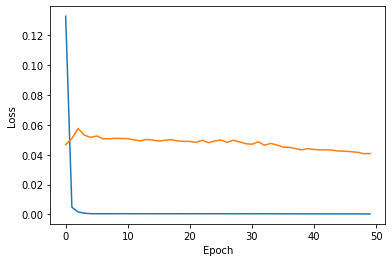

In [165]:
#plot learning curves
plt.plot(h.history['loss'],label='train_loss')
plt.plot(h.history['val_loss'],label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [166]:
# make predictions
trainPredict = model_lstm.predict(trainX)
testPredict = model_lstm.predict(testX)

In [167]:
testPredict[:5]

array([[0.21886776],
       [0.28936666],
       [0.3380063 ],
       [0.36132288],
       [0.37811804]], dtype=float32)

In [169]:
# invert predictions
trainPredict_ = scaler_train.inverse_transform(trainPredict)
trainY_ = scaler_train.inverse_transform([trainY])
testPredict_ = scaler_test.inverse_transform(testPredict)
testY_ = scaler_test.inverse_transform([testY])

In [170]:
trainPredict_[:5]

array([[327.7547 ],
       [323.51462],
       [319.38293],
       [316.86594],
       [314.2467 ]], dtype=float32)

### Evaluate the model

In [171]:
# calculate root mean squared error and mean absolute error on the train and the test data
trainScore = np.sqrt(mean_squared_error(trainY_[0], trainPredict_[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY_[0], testPredict_[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

print('\nTrain Score: %.2f MAE' % (mean_absolute_error(trainY_[0], trainPredict_[:,0])))
print('Test Score: %.2f MAE' % (mean_absolute_error(testY_[0], testPredict_[:,0])))

Train Score: 10.15 RMSE
Test Score: 10.57 RMSE

Train Score: 6.84 MAE
Test Score: 8.16 MAE


### Visualize the predictions in a single graph

In [172]:
dataframe = pd.concat([train.High, test.High])

In [173]:
print(trainPredict_.shape, testPredict_.shape)

(1252, 1) (14, 1)


In [174]:
dataframe.shape

(1278,)

In [175]:
dataframe = pd.DataFrame(dataframe.values, index=dataframe.index, columns=['high'])
dataframe['train_pred'] = np.nan
dataframe['test_pred']  = np.nan

dataframe.iloc[n_steps_in:n_steps_in+len(trainPredict_), 1] = trainPredict_[:,0]
dataframe.iloc[-len(testPredict_):, 2] = testPredict_[:,0]

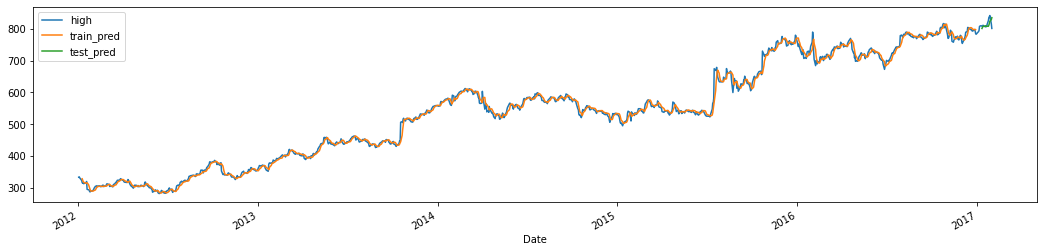

In [178]:
dataframe.plot(figsize=(18,4))
plt.show()

# 3. Many to One - Stacked RNN, LSTM

Create a stacked RNN/LSTM with 2 LSTM layers.
The other parameters are the same as in the example before.

In [180]:
# create and fit the model
def two_layered_RNN(input_shape, num_neurons):
  _input = Input(shape=input_shape, dtype='float')
  x = GRU(2*num_neurons, activation='relu', input_shape=input_shape, 
                return_sequences=True, name='hidden_1')(_input)
  x = LSTM(num_neurons, activation='relu', input_shape=input_shape)(x)
  output = Dense(1)(x)
  my_model = Model(inputs=[_input], outputs=[output])
  optimizer = Adam()
  my_model.compile(optimizer=optimizer,loss='mse')
  return my_model

num_features = trainX.shape[2]
num_timestamps = trainX.shape[1]
input_shape = (num_timestamps, num_features)
model_stack =  two_layered_RNN(input_shape, num_neurons=15)
model_stack.summary()


Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
hidden_1 (GRU)               (None, 5, 30)             2970      
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                2760      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 16        
Total params: 5,746
Trainable params: 5,746
Non-trainable params: 0
_________________________________________________________________


In [181]:
callback1_stack = ModelCheckpoint('best_stack.pt', monitor='loss', save_best_only=True, mode='min', verbose=1)
callback2_stack = EarlyStopping(patience=20, monitor='loss', mode='min')
callback_list_stack = [callback1_stack, callback2_stack]

In [182]:
# make predictions
h_stack = model_stack.fit(trainX, trainY,
                   epochs= 50,
                   batch_size=20,
                   callbacks=callback_list,
                   validation_data=(testX, testY),
                   verbose=0)


Epoch 00001: loss did not improve from 0.00038

Epoch 00002: loss did not improve from 0.00038

Epoch 00003: loss did not improve from 0.00038

Epoch 00004: loss did not improve from 0.00038

Epoch 00005: loss did not improve from 0.00038

Epoch 00006: loss did not improve from 0.00038

Epoch 00007: loss did not improve from 0.00038

Epoch 00008: loss did not improve from 0.00038

Epoch 00009: loss did not improve from 0.00038

Epoch 00010: loss did not improve from 0.00038

Epoch 00011: loss did not improve from 0.00038

Epoch 00012: loss did not improve from 0.00038

Epoch 00013: loss did not improve from 0.00038

Epoch 00014: loss did not improve from 0.00038

Epoch 00015: loss did not improve from 0.00038

Epoch 00016: loss did not improve from 0.00038

Epoch 00017: loss did not improve from 0.00038

Epoch 00018: loss did not improve from 0.00038

Epoch 00019: loss did not improve from 0.00038

Epoch 00020: loss did not improve from 0.00038

Epoch 00021: loss did not improve from 

### Evaluate the model

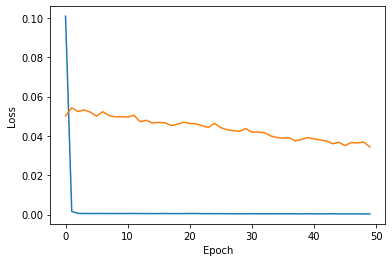

In [183]:
#plot learning curves
plt.plot(h_stack.history['loss'],label='train_loss')
plt.plot(h_stack.history['val_loss'],label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [184]:
# make predictions
trainPredict = model_stack.predict(trainX)
testPredict = model_stack.predict(testX)

In [185]:
# invert predictions
trainPredict_ = scaler_train.inverse_transform(trainPredict)
trainY_ = scaler_train.inverse_transform([trainY])
testPredict_ = scaler_test.inverse_transform(testPredict)
testY_ = scaler_test.inverse_transform([testY])

In [186]:
# calculate root mean squared error and mean absolute error on the train and the test data
trainScore = np.sqrt(mean_squared_error(trainY_[0], trainPredict_[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY_[0], testPredict_[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

print('\nTrain Score: %.2f MAE' % (mean_absolute_error(trainY_[0], trainPredict_[:,0])))
print('Test Score: %.2f MAE' % (mean_absolute_error(testY_[0], testPredict_[:,0])))

Train Score: 10.74 RMSE
Test Score: 9.70 RMSE

Train Score: 7.96 MAE
Test Score: 7.40 MAE


### Visualize the predictions

In [190]:
dataframe['train_pred'] = np.nan
dataframe['test_pred']  = np.nan

dataframe.iloc[n_steps_in:n_steps_in+len(trainPredict_), 1] = trainPredict_[:,0]
dataframe.iloc[-len(testPredict_):, 2] = testPredict_[:,0]

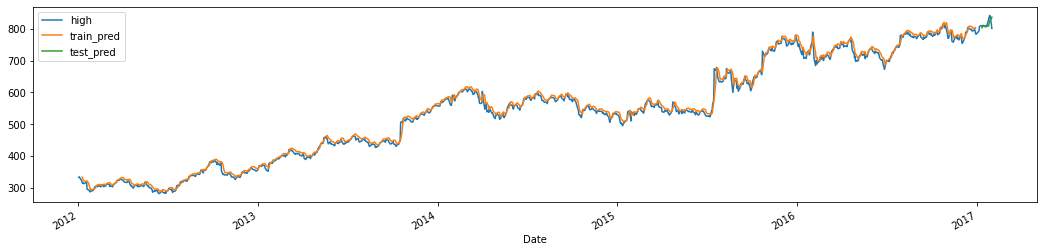

In [191]:
dataframe.plot(figsize=(18,4))
plt.show()

# 5. Many to Many

## Prepare the data in appropriate format

In [192]:
# function that segments the data
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [196]:
# choose a number of time steps
n_steps_in, n_steps_out = 5, 2
n_features = 1
# split into samples
trainX, trainY = split_sequence(sequence_train, n_steps_in, n_steps_out)
testX, testY = split_sequence(sequence_test, n_steps_in, n_steps_out)
# summarize the data
for i in range(3):
	print(testX[i], "\n Y: "  ,testY[i])

[[0.        ]
 [0.03268349]
 [0.09269878]
 [0.34919725]
 [0.38876147]] 
 Y:  [[0.37270642]
 [0.35397554]]
[[0.03268349]
 [0.09269878]
 [0.34919725]
 [0.38876147]
 [0.37270642]] 
 Y:  [[0.35397554]
 [0.33944954]]
[[0.09269878]
 [0.34919725]
 [0.38876147]
 [0.37270642]
 [0.35397554]] 
 Y:  [[0.33944954]
 [0.41265291]]


In [197]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1252, 5, 1) (1252, 2, 1) (14, 5, 1) (14, 2, 1)


In [200]:
# There are 2 (n_steps_out) predictions for each data point. 
# testX[::n_steps_out].shape, testY[::n_steps_out].shape

## Create the model

In [233]:
# create and fit the RNN/LSTM network. 
# Use encoder LSTM with 100 neurons, decoder LSTM with 100 enaurons
# RELU activation function, MAE as a loss, and RELU as optimizer.

def LSTM_model_many(input_shape, num_neurons, n_steps_out):
  _input = Input(shape=input_shape, dtype='float', name='m_input')
  x = GRU(num_neurons, activation='relu')(_input)
  x= RepeatVector(n_steps_out)(x)
  x = GRU(num_neurons, activation='relu', return_sequences=True)(x)
  output =Dense(1)(x)
  my_model = Model(inputs=[_input], outputs=[output])
  optimizer = Adam()
  my_model.compile(optimizer=optimizer, loss='mae')
  return my_model
 
num_features = trainX.shape[2]
num_timestamps = trainX.shape[1]
input_shape = (num_timestamps, num_features)
num_neurons= 10
del model
model = LSTM_model_many(input_shape, num_neurons, n_steps_out)
model.summary()



Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_input (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 10)                390       
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 2, 10)             0         
_________________________________________________________________
gru_6 (GRU)                  (None, 2, 10)             660       
_________________________________________________________________
dense_13 (Dense)             (None, 2, 1)              11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


## Make the predictions

In [234]:
callback1 = ModelCheckpoint('best_model.pt', monitor='loss', save_best_only=True, mode='min', verbose=1)
callback2 = EarlyStopping(patience=20, monitor='loss', mode='min')
callback_list = [callback1, callback2]


In [235]:
# make predictions
h = model.fit(trainX, trainY, 
          epochs=40, 
          batch_size=10,
          callbacks = callback_list, 
          validation_data=(testX, testY),
          verbose=0)


Epoch 00001: loss improved from inf to 0.42817, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets

Epoch 00002: loss improved from 0.42817 to 0.34108, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets

Epoch 00003: loss improved from 0.34108 to 0.25800, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets

Epoch 00004: loss improved from 0.25800 to 0.18262, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets

Epoch 00005: loss improved from 0.18262 to 0.12393, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets

Epoch 00006: loss improved from 0.12393 to 0.09283, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets

Epoch 00007: loss improved from 0.09283 to 0.07413, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets

Epoch 00008: loss improved fro

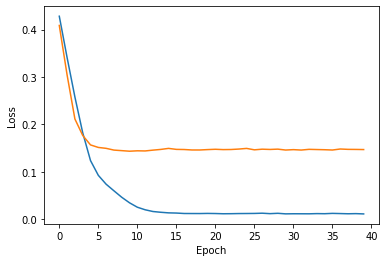

In [236]:
#plot learning curves
plt.plot(h.history['loss'],label='train_loss')
plt.plot(h.history['val_loss'],label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [237]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [240]:
# invert predictions from normalized values to real values for 1-step predictions
trainPredict_1 = scaler_train.inverse_transform(trainPredict[:,0])
trainY_1 = scaler_train.inverse_transform(trainY[:,0])
testPredict_1 = scaler_test.inverse_transform(testPredict[:,0])
testY_1 = scaler_test.inverse_transform(testY[:,0])


# invert predictions from normalized values to real values for 2-step predictions
trainPredict_2 = scaler_train.inverse_transform(trainPredict[:,1])
trainY_2 = scaler_train.inverse_transform(trainY[:,1])
testPredict_2 = scaler_test.inverse_transform(testPredict[:,1])
testY_2 = scaler_test.inverse_transform(testY[:,1])

## Calculate the RMSE and MAE for the train and test data

Note: Reshape the predictions in approriate format

In [241]:
# calculate and print evaluation metrics
trainScore = np.sqrt(mean_squared_error(trainY_1[:,0], trainPredict_1[:,0]))
print('1-step Train RMSE: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY_1[:,0], testPredict_1[:,0]))
print('1-step Test RMSE: %.2f RMSE' % (testScore))

print('1-step Train MAE: %.2f MAE' % (mean_absolute_error(trainY_1[:,0], trainPredict_1[:,0])))
print('1-step Test MAE: %.2f MAE' % (mean_absolute_error(testY_1[:,0], testPredict_1[:,0])))


trainScore = np.sqrt(mean_squared_error(trainY_2[:,0], trainPredict_2[:,0]))
print('\n2-steps Train RMSE: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY_2[:,0], testPredict_2[:,0]))
print('2-steps Test RMSE: %.2f RMSE' % (testScore))

print('2-steps Train MAE: %.2f MAE' % (mean_absolute_error(trainY_2[:,0], trainPredict_2[:,0])))
print('2-steps Test MAE: %.2f MAE' % (mean_absolute_error(testY_2[:,0], testPredict_2[:,0])))

1-step Train RMSE: 7.53 RMSE
1-step Test RMSE: 8.40 RMSE
1-step Train MAE: 4.64 MAE
1-step Test MAE: 5.45 MAE

2-steps Train RMSE: 11.23 RMSE
2-steps Test RMSE: 14.48 RMSE
2-steps Train MAE: 7.33 MAE
2-steps Test MAE: 9.95 MAE


## Visualize the predictions

In [267]:

#dataframe = dataframe.drop(['train_pred', 'test_pred'], axis=1)
dataframe['train_pred_1'] = np.nan
dataframe['test_pred_1']  = np.nan
dataframe['train_pred_2'] = np.nan
dataframe['test_pred_2']  = np.nan
dataframe['trainY_1'] = np.nan
dataframe['trainY_2'] = np.nan
dataframe['testY_1'] = np.nan
dataframe['testY_2'] = np.nan


dataframe.iloc[n_steps_in:n_steps_in+len(trainPredict_1), 1] = trainPredict_1[:,0]
dataframe.iloc[-len(testPredict_1):, 2] = testPredict_1[:,0]
dataframe.iloc[n_steps_in:n_steps_in+len(trainPredict_2), 3] = trainPredict_2[:,0]
dataframe.iloc[-len(testPredict_2):, 4] = testPredict_2[:,0]

dataframe.iloc[n_steps_in:n_steps_in+len(trainY_1), 5] = trainY_1[:,0]
dataframe.iloc[-len(testY_1):, 7] = testY_1[:,0]
dataframe.iloc[n_steps_in:n_steps_in+len(trainY_2), 6] = trainY_2[:,0]
dataframe.iloc[-len(testY_2):, 8] = testY_2[:,0]

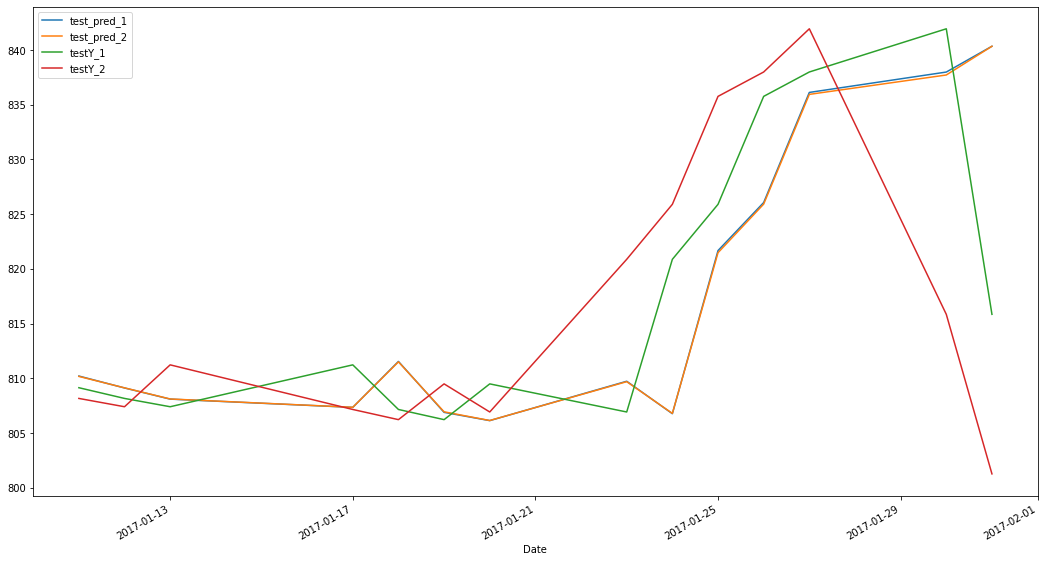

In [272]:
# plot the Test predicitons and the whole test set
dataframe[['test_pred_1', 'test_pred_2', 'testY_1', 'testY_2']].plot(figsize=(18,10))
plt.show()

In [266]:
# plot only the Test predicitons (no empty predictions at the beginning and the end)


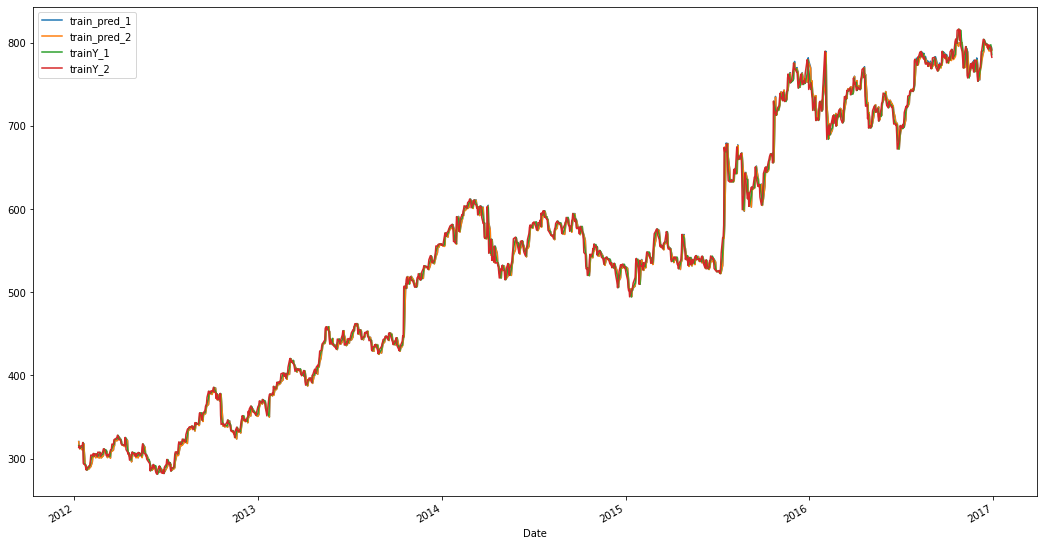

In [273]:
# plot the Train data and predicitons
dataframe[['train_pred_1', 'train_pred_2', 'trainY_1', 'trainY_2']].plot(figsize=(18,10))
plt.show()


# 7. Create the best performing model.

Use different parameters of the newtorks, different optimizers, add features (optionally) ...

In [3]:
train = pd.read_csv('/content/Google_Stock_Price_Train.csv')
test = pd.read_csv('/content/Google_Stock_Price_Test.csv')

In [4]:
dataframe = pd.concat([train, test], axis=0)

In [5]:
dataframe = dataframe.drop(['Open', 'Low', 'Close', 'Volume'], axis=1)
dataframe.Date = pd.to_datetime(dataframe.Date, format='%m/%d/%Y')

In [6]:
dataframe = dataframe.set_index('Date')

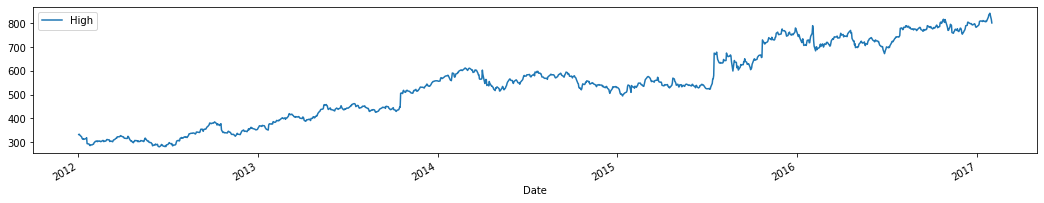

In [7]:
# plot the dataset
dataframe.plot(figsize = (18,3))
plt.show()

In [8]:
#calculate first derivative and second derivative
derivative_1 = dataframe.High.diff()
derivative_2 = dataframe.High.diff().diff()

# add them to the dataframe
dataframe['deriv_1'] = derivative_1
dataframe['deriv_2'] = derivative_2
dataframe.fillna(0,inplace=True)

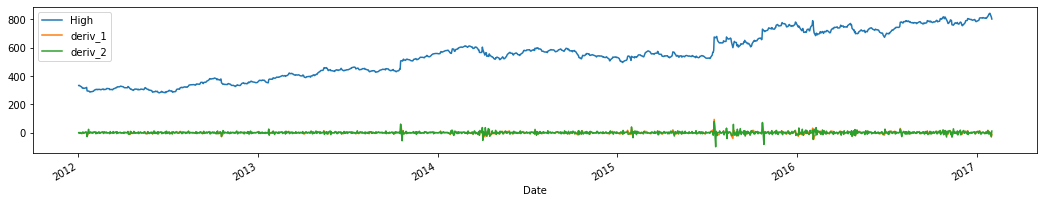

In [9]:
# plot the dataset
dataframe.plot(figsize = (18,3))
plt.show()

In [10]:
# split  into samples
def split_multivariate_sequence(sequence, n_steps_in, n_steps_out):
	X, y = [], []
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix,0]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [11]:
# normalize the dataset
X = dataframe.values.astype('float')

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X.shape

(1278, 3)

In [12]:
# split into train and test sets. Use first 70% of the data as trianing and last 30% as test
train_size = len(train)
test_size = len(X) - train_size
train, test = X[:train_size,:], X[train_size:len(X),:]
train.shape, test.shape

((1258, 3), (20, 3))

In [13]:
#split to train and test 
look_back = 5
n_steps_out = 2
trainX, trainY = split_multivariate_sequence(train, look_back, n_steps_out)
testX, testY = split_multivariate_sequence(test, look_back, n_steps_out)

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1252, 5, 3) (1252, 2) (14, 5, 3) (14, 2)


In [15]:
# define model
from keras.layers import GRU
def LSTM_model_many(imput_shape,num_neurons,n_steps_out):
  _input = Input(shape=input_shape,dtype='float', name='m_input')
  x = GRU(num_neurons, activation='relu')(_input)
  x= RepeatVector(n_steps_out)(x)
  x = LSTM(num_neurons, activation='relu', return_sequences=True)(x)
  output =Dense(1)(x)
  my_model = Model(inputs=[_input], outputs=[output])
  optimizer = Adam()
  my_model.compile(optimizer=optimizer,loss='mae')
  return my_model
 
num_features = trainX.shape[2]
num_timestamps = trainX.shape[1]
input_shape = (num_timestamps, num_features)
num_neurons = 7
model = LSTM_model_many(input_shape,num_neurons,n_steps_out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_input (InputLayer)         [(None, 5, 3)]            0         
_________________________________________________________________
gru (GRU)                    (None, 7)                 252       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 7)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 2, 7)              420       
_________________________________________________________________
dense (Dense)                (None, 2, 1)              8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________


In [16]:
callback1 = ModelCheckpoint('best_model.pt', monitor='loss', save_best_only=True, mode='min', verbose=1)
callback2 = EarlyStopping(patience=20, monitor='loss', mode='min')
callback_list = [callback1, callback2]

In [17]:
h = model.fit(trainX, trainY, 
              batch_size=15,
              epochs=50,
              callbacks=callback_list,
              validation_data=(testX, testY),
              verbose=1)

Epoch 1/50
82/84 [============================>.] - ETA: 0s - loss: 0.2981
Epoch 00001: loss improved from inf to 0.29598, saving model to best_model.pt
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model.pt/assets
84/84 [==============================] - 4s 52ms/step - loss: 0.2960 - val_loss: 0.3182
Epoch 2/50
83/84 [============================>.] - ETA: 0s - loss: 0.1580
Epoch 00002: loss improved from 0.29598 to 0.15775, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
84/84 [==============================] - 4s 49ms/step - loss: 0.1578 - val_loss: 0.2118
Epoch 3/50
82/84 [============================>.] - ETA: 0s - loss: 0.1063
Epoch 00003: loss improved from 0.15775 to 0.10627, saving model to best_model.pt
INFO:tensor

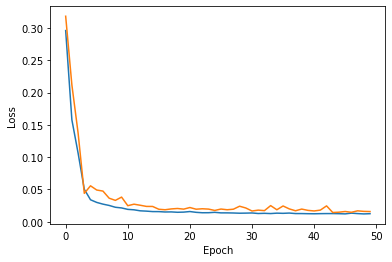

In [18]:
# plot the learning curves
plt.plot(h.history['loss'],label='train_loss')
plt.plot(h.history['val_loss'],label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [20]:
# invert predictions from normalized values to real values for 1-step predictions
#the scaler expect the same input_shape as the one uset to fit it (num_instances,num_features)
#however, we need to rescale only the predictions, so we will use a temporary variable (tmp) to match the required shape
tmp = np.column_stack(np.repeat(trainPredict[:,0],3).reshape(len(trainPredict),3).T)

#now we can use the scaler
trainPredict_1 = scaler.inverse_transform(tmp)[:,0]

#the same procedure is required for all variables that we would like to rescale
tmp = np.column_stack(np.repeat(trainY[:,0],3).reshape(len(trainY),3).T)
trainY_1 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(testPredict[:,0],3).reshape(len(testPredict),3).T)
testPredict_1 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(testY[:,0],3).reshape(len(testY),3).T)
testY_1 = scaler.inverse_transform(tmp)[:,0]


# invert predictions from normalized values to real values for 2-step predictions
tmp = np.column_stack(np.repeat(trainPredict[:,1],3).reshape(len(trainPredict),3).T)
trainPredict_2 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(trainY[:,1],3).reshape(len(trainY),3).T)
trainY_2 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(testPredict[:,1],3).reshape(len(testPredict),3).T)
testPredict_2 = scaler.inverse_transform(tmp)[:,0]

tmp = np.column_stack(np.repeat(testY[:,1],3).reshape(len(testY),3).T)
testY_2 = scaler.inverse_transform(tmp)[:,0]

In [21]:

# calculate and print evaluation metrics
trainScore = np.sqrt(mean_squared_error(trainY_1, trainPredict_1))
print('1-step Train RMSE: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY_1, testPredict_1))
print('1-step Test RMSE: %.2f RMSE' % (testScore))

print('1-step Train MAE: %.2f MAE' % (mean_absolute_error(trainY_1, trainPredict_1)))
print('1-step Test MAE: %.2f MAE' % (mean_absolute_error(testY_1, testPredict_1)))


trainScore = np.sqrt(mean_squared_error(trainY_2, trainPredict_2))
print('\n2-steps Train RMSE: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY_2, testPredict_2))
print('2-steps Test RMSE: %.2f RMSE' % (testScore))

print('2-steps Train MAE: %.2f MAE' % (mean_absolute_error(trainY_2, trainPredict_2)))
print('2-steps Test MAE: %.2f MAE' % (mean_absolute_error(testY_2, testPredict_2)))

1-step Train RMSE: 8.67 RMSE
1-step Test RMSE: 10.53 RMSE
1-step Train MAE: 5.88 MAE
1-step Test MAE: 7.27 MAE

2-steps Train RMSE: 11.69 RMSE
2-steps Test RMSE: 14.44 RMSE
2-steps Train MAE: 7.94 MAE
2-steps Test MAE: 10.38 MAE


In [22]:
#plot predictions
dataframe['1-step-train_pred'] = np.nan
dataframe['2-step-test_pred'] = np.nan

In [23]:

dataframe.iloc[look_back:look_back+len(trainPredict_1),3]= trainPredict_1
dataframe.iloc[-len(testPredict_1):,3]= testPredict_1

dataframe.iloc[look_back:look_back+len(trainPredict_1),4]= trainPredict_2
dataframe.iloc[-len(testPredict_2):,4]= testPredict_2

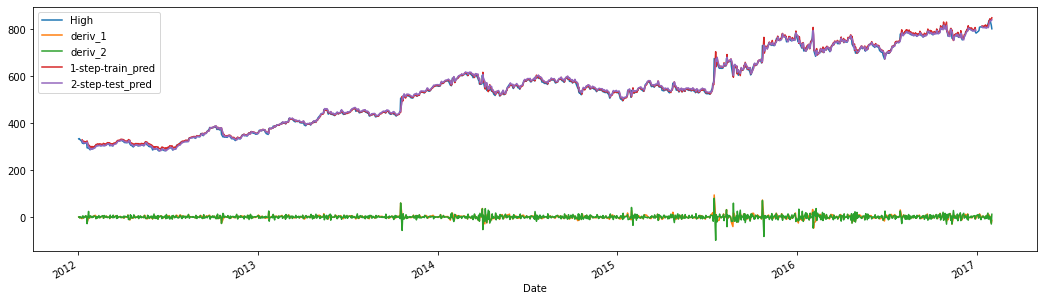

In [24]:
dataframe.plot(figsize=(18,5))
plt.show()